Usando un dataset de noticias, pej: este en español sobre noticias de los diarios La Razón y Público (aunque se puede usar cualquier otro, pero debe ser en español), he implementado una aplicación de chat para interactuar con las noticias y poder realizar preguntas sobre ellas.

Para este ejercicio he escogido el modelo Llama2.

In [ ]:
#instalamos las librerias necesarias:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not curr

In [ ]:
#importamos las librerias:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

In [ ]:
#descargamos el dataset de noticias:
%%bash
cp ./kaggle.json /root/.kaggle/kaggle.json
kaggle datasets download -d josemamuiz/noticias-laraznpblico
unzip noticias-laraznpblico.zip -d ./data

Dataset URL: https://www.kaggle.com/datasets/josemamuiz/noticias-laraznpblico
License(s): unknown

Archive:  noticias-laraznpblico.zip
  inflating: ./data/data_larazon_publico_v2.csv  


cp: cannot stat './kaggle.json': No such file or directory
100%|██████████| 87.4M/87.4M [00:04<00:00, 19.0MB/s]


In [ ]:
import pandas as pd
data_larazon = pd.read_csv("./data/data_larazon_publico_v2.csv")

In [ ]:
data_larazon = data_larazon[['cuerpo', 'titular']]

In [ ]:
data_larazon

,cuerpo,titular
0,dos semanas después de su puesta de largo y pr...,el submarino s-80 ya flota
1,"este viernes, el presidente del gobierno, pedr...",calviño y calvo alaban (sin darse cuenta) la g...
2,"el ministro del interior, fernando grande-marl...",el geo de la policía tendrá una nueva sede en ...
3,son días muy duros para la familia de olivia y...,"la madre de las niñas ""sobran las palabras par..."
4,sólo quedan 10 presos de eta por recibir los b...,sólo quedan 10 presos de eta por recibir el be...
...,...,...
58419,la comisión europea inició este un procedimien...,bruselas abre un expediente a españa por no de...
58420,el pleno de la asamblea de madrid ha aprobado ...,aprobado el proyecto de ley para que las mujer...
58421,la comisión de investigación parlamentaria del...,la comisión del alvia arranca escuchando a la ...
58422,"erc y pdecat han calificado este jueves de ""in...",erc y pdecat piden explicaciones a interior po...


In [ ]:
#Cambiamos el formato del dataset de noticias
from datasets import Dataset

def combine_columns(row):
    return f"<s>[INST] {row['titular']} [/INST] {row['cuerpo']} </s>"

data_larazon['text'] = data_larazon.apply(combine_columns, axis=1)

data_larazon_definitivo = data_larazon[['text']]
data_larazon_definitivo = Dataset.from_pandas(data_larazon_definitivo)

print(data_larazon_definitivo)

Dataset({
    features: ['text'],
    num_rows: 58424
})


In [ ]:
print("Primeras 5 filas del dataset:")
print(data_larazon_definitivo['text'][:5])

Primeras 5 filas del dataset:
['<s>[INST] el submarino s-80 ya flota [/INST] dos semanas después de su puesta de largo y presentación en sociedad, el primer submarino s-80 para la armada, el s-81 "isaac peral", ha entrado hoy en el agua tras una delicada y larga maniobra que se ha retrasado varios días por las condiciones meteorológicas. de esta forma, tras completar su construcción 17 años después de que arrancara el programa, navantia ha cumplido otro importante hito.españa.submarino s-80 tras 17 años y 3.900 millones, el "isaac peral" ya está aquíespaña.el comandante del s-81 isaac peral» va a ser un revulsivo para la armada»desde que el pasado día 22 la princesa leonor amadrinara el que es considerado uno de los submarinos (no nucleares) más avanzados del mundo, en el astillero de navantia de cartagena (murcia) comenzaron las tareas que llevarían al s-80 al agua. un lento y delicado trabajo que comenzó con su colocación sobre un dique flotante. tras esto, se ha hecho flotar el diqu

Como entrenar un modelo asi es muy costoso computacionalmente, he decidido usar solamente las primeras 25.000 noticias de nuestro dataset.

In [ ]:
data_larazon_definitivo = data_larazon_definitivo.select(range(25000))

In [ ]:
print("Primeras 5 filas del dataset:")
print(data_larazon_definitivo['text'][:5])

Primeras 5 filas del dataset:
['<s>[INST] el submarino s-80 ya flota [/INST] dos semanas después de su puesta de largo y presentación en sociedad, el primer submarino s-80 para la armada, el s-81 "isaac peral", ha entrado hoy en el agua tras una delicada y larga maniobra que se ha retrasado varios días por las condiciones meteorológicas. de esta forma, tras completar su construcción 17 años después de que arrancara el programa, navantia ha cumplido otro importante hito.españa.submarino s-80 tras 17 años y 3.900 millones, el "isaac peral" ya está aquíespaña.el comandante del s-81 isaac peral» va a ser un revulsivo para la armada»desde que el pasado día 22 la princesa leonor amadrinara el que es considerado uno de los submarinos (no nucleares) más avanzados del mundo, en el astillero de navantia de cartagena (murcia) comenzaron las tareas que llevarían al s-80 al agua. un lento y delicado trabajo que comenzó con su colocación sobre un dique flotante. tras esto, se ha hecho flotar el diqu

In [ ]:
model_name = "NousResearch/Llama-2-7b-chat-hf"

# Nombre de mi modelo después del fine-tunning.
new_model = "llama-2-7b-la_razon_definitivo"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = True

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

In [ ]:
# Cargar el modelo con la configuración QLora
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

trainer = SFTTrainer(
    model=model,
    train_dataset=data_larazon_definitivo,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

trainer.train()

trainer.model.save_pretrained(new_model)

Your GPU supports bfloat16: accelerate training with bf16=True


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type:

Step,Training Loss
25,2.749300
50,2.613200
75,2.338000
100,2.194100
125,2.174000
150,2.059700
175,1.960600
200,2.001500
225,1.836800
250,1.960100


El entrenamiento ha tardado unas 3H30min y he tenido que usar la GPU A100 de colab.

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir results/runs

In [ ]:
data_larazon_definitivo[9118]["text"]

'<s>[INST] la hora de la gran desbandada [/INST] preludio. esa es la palabra que viene a la cabeza cuando despierta benidorm, en el primer día de su nueva vida. como el olor a tierra mojada antes de la tormenta. desde hoy, la urbe de vacaciones por excelencia del levante español abre sus puertas al turismo nacional, dado que el internacional ya tenía permitida la entrada desde hace meses. la ciudad que nunca dormía y que, antes de la pandemia, enlazaba temporadas y temporadas de lleno total, se despereza con timidez. este es el primer fin de semana de buen tiempo desde hace un mes, otro buen presagio.sociedad.guía práctica para la desescalada mientras se ha mantenido el cierre perimetral en la comunidad valenciana, benidorm ha sido un destino turístico local de viernes a domingo. en estos momentos, hay abiertos 38 establecimientos turísticos y ya se ha programado la apertura de otros 29 más, lo que supone pasar del 23 al 46% de las plazas hoteleras. la ciudad se prepara para un verano 

In [ ]:
prompt = "Me podrias hablar de la cientifica isabel solas?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=1000)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] Me podrias hablar de la cientifica isabel solas? [/INST] ¡Por supuesto! Isabel Solas es una de las científicas españolas más reconocidas en el mundo en el campo de la biología molecular y la genética. la profesora de genética molecular de la universidad de valencia, es conocida por su trabajo en el campo de la genética molecular y la biología molecular, y por ser una de las investigadoras más reconocidas en el mundo en el campo de la genética molecular y la biología molecular.especialmente por su trabajo en el campo de la genética molecular y la biología molecular, y por ser una de las investigadoras más reconocidas en el mundo en el campo de la genética molecular y la biología molecular.especialmente por su trabajo en el campo de la genética molecular y la biología molecular, y por ser una de las investigadoras más reconocidas en el mundo en el campo de la genética molecular y la biología molecular.especialmente por su trabajo en el campo de la genética molecular y la biolog

In [ ]:
data_larazon_definitivo[1444]["text"]

'<s>[INST] los indicios que sitúan a albert rivera tras la estampida de miembros de ciudadanos hacia el pp [/INST] la desbandada que inician cargos y afiliados de ciudadanos tras el malestar interno con la hoja de ruta de la actual dirección encabezada por inés arrimadas de acercamiento al psoe viene de lejos y apunta, a todas luces, al paso decidido del ex presidente albert rivera de abrir el camino de paso entre la formación naranja y el pp.españa.ciudadanos denuncia que el pp "paga" a sus disidentesespaña.críticos exigen que la asamblea de cs se reúna para veranolas ganas del propio rivera de volver al tablero político unido a su apuesta firme por una unión del centro derecha que sea capaz de vencer a pedro sánchez en las urnas son las primeras señales que apuntan a esta operación iniciada ya por el entorno crítico con cs y que se ha saldado, de hecho, con el primer movimiento que deja al partido naranja tocado y hundido bajo las exigencias de los barones autonómicos de un cambio de

In [ ]:
# Empty VRAM
del model
del pipe
del trainer
import gc
gc.collect()
gc.collect()

30672

In [ ]:
# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/peft/peft_model.py:556: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  adapters_weights = torch.load(


Hacemos 'login' en HF.

In [ ]:
from huggingface_hub import login
from google.colab import userdata

token = userdata.get('HF_TOKEN')
login(token=token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Subimos el modelo a HF.

In [ ]:
model.push_to_hub(new_model, use_temp_dir=False)

tokenizer.push_to_hub(new_model, use_temp_dir=False)


pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Luismarti97/llama-2-7b-la_razon_definitivo/commit/c360011fb8fcc7e85337552ae01fc889aa5371e0', commit_message='Upload tokenizer', commit_description='', oid='c360011fb8fcc7e85337552ae01fc889aa5371e0', pr_url=None, pr_revision=None, pr_num=None)

Probamos el modelo.

In [ ]:
# Cargar el modelo y el tokenizador desde Hugging Face
model_name = "Luismarti97/llama-2-7b-la_razon_definitivo"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

chatbot_pipeline = pipeline("text-generation", model=model, tokenizer=tokenizer, max_length=1000, do_sample=True, top_p=0.95, temperature=0.8)

def chatbot_interaction(prompt):
    formatted_prompt = f"<s>[INST] {prompt} [/INST]"
    result = chatbot_pipeline(formatted_prompt)
    print(result[0]['generated_text'])

print("¡Bienvenido al chatbot! Escribe 'salir' para terminar la conversación.")
while True:
    user_input = input("Tú: ")
    if user_input.lower() == "salir":
        break
    chatbot_interaction(user_input)

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:460: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cp

generation_config.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


¡Bienvenido al chatbot! Escribe 'salir' para terminar la conversación.
Tú: salir


In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.0/94.0 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: tomlkit
    Found existing 

In [ ]:
import gradio as gr
def generar_respuesta(prompt, temperatura, max_tokens):
    formatted_prompt = f"<s>[INST] {prompt} [/INST]"

    chatbot_pipeline = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        max_length=max_tokens,
        do_sample=True,
        temperature=temperatura,
        top_p=0.95
    )

    result = chatbot_pipeline(formatted_prompt)
    return result[0]['generated_text']

def chatbot_interface(input_text, temperature, max_output_tokens):
    respuesta = generar_respuesta(input_text, temperature, max_output_tokens)
    return respuesta

with gr.Blocks() as interfaz:
    gr.Markdown("## Chatbot basado en Llama-2 con Gradio")

    input_text = gr.Textbox(label="Introduce tu pregunta", placeholder="Escribe aquí...", lines=2)
    output_text = gr.Textbox(label="Respuesta del chatbot")

    temperatura = gr.Slider(0.1, 1.0, value=0.8, label="Temperatura (Controla la creatividad)")
    max_output_tokens = gr.Slider(50, 1000, value=500, step=50, label="Número máximo de tokens de salida")

    boton_enviar = gr.Button("Generar Respuesta")

    boton_enviar.click(fn=chatbot_interface, inputs=[input_text, temperatura, max_output_tokens], outputs=output_text)

if __name__ == "__main__":
    interfaz.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://59aad6a7409f851694.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
data_larazon_definitivo[8990]["text"]

'<s>[INST] los reyes muestran su apoyo al trabajo de ganaderos y agricultores durante la pandemia [/INST] los reyes han visitado esta mañana la sociedad agraria de transformación "vega de san martín", en la localidad de san martín de la vega, en la comunidad de madrid. durante la visita han estado acompañados por la presidenta de la comunidad de madrid, isabel díaz ayuso el ministro de agricultura, luis planas el alcalde de san martín de la vega, rafael martínez y la consejera de medio ambiente, ordenación del territorio y sostenibilidad de la comunidad de madrid, paloma martín. los tres máximos responsables de la explotación agroganadera, eva esteban, presidenta iván esteban, gerente y francisco esteban, director comercial, han explicado a los reyes las características de la sociedad agraria de transformación que regentan desde hace 30 años, como continuación a la larga tradición familiar agrícola y ganadera, con origen en cuenca la visita se a producido en el marco de los diversos co

Las respuestas que me ha dado no siempre tienen coherencia, pero se pueden entender y tienen sentido gramatical.

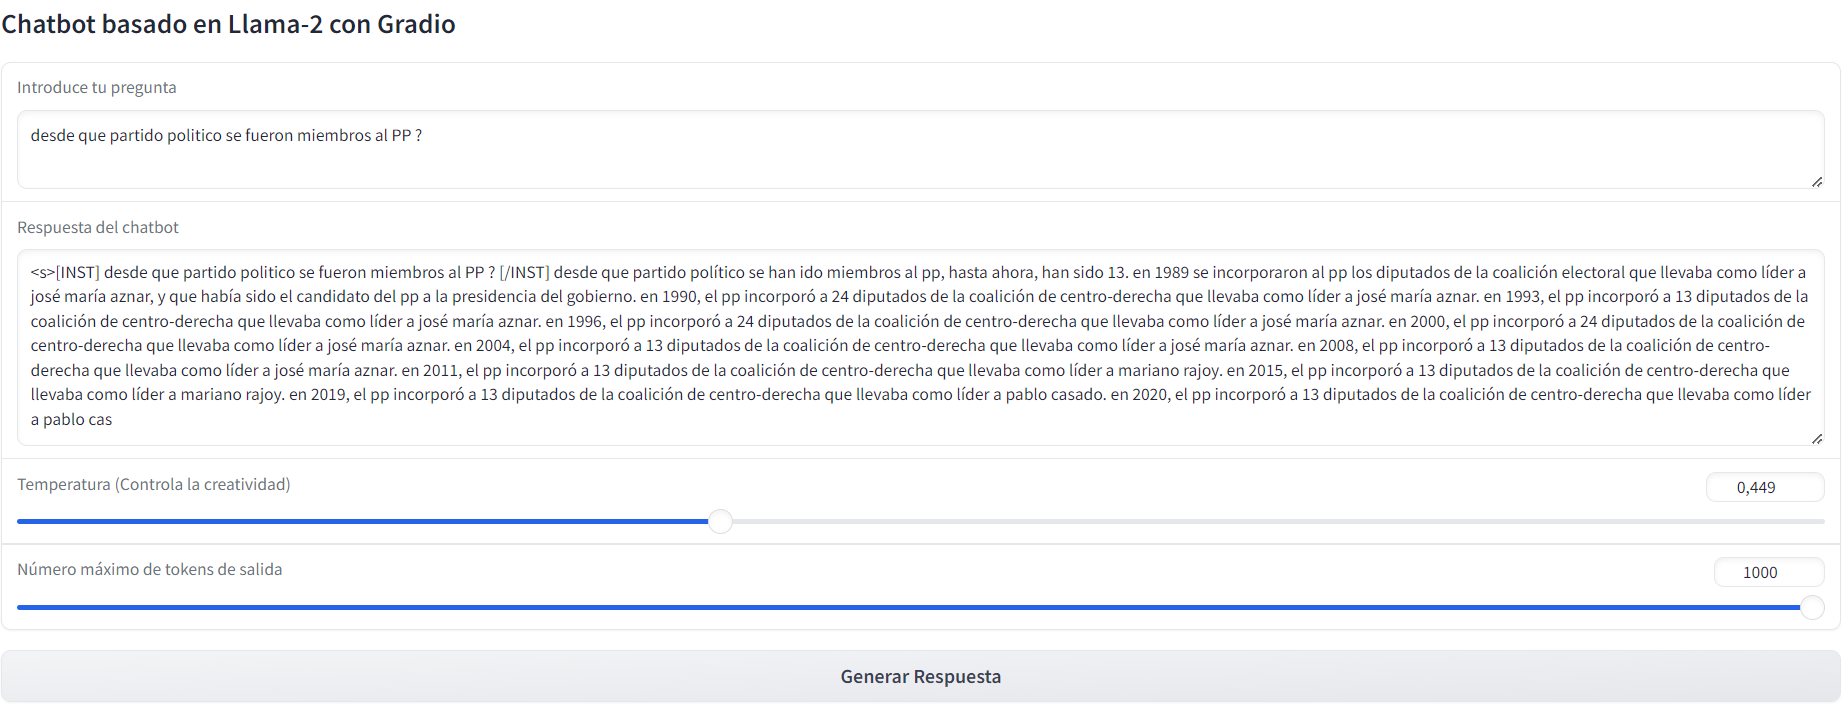

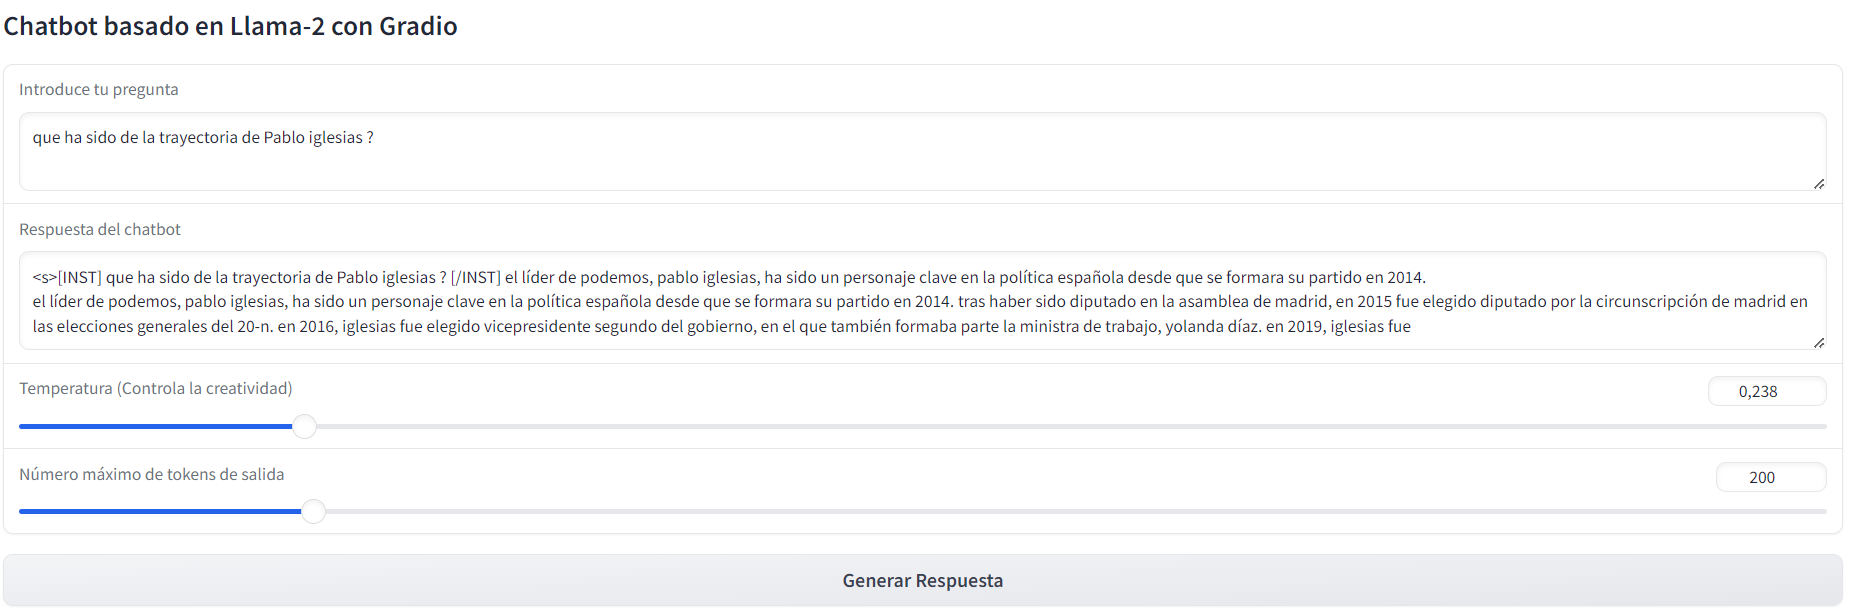

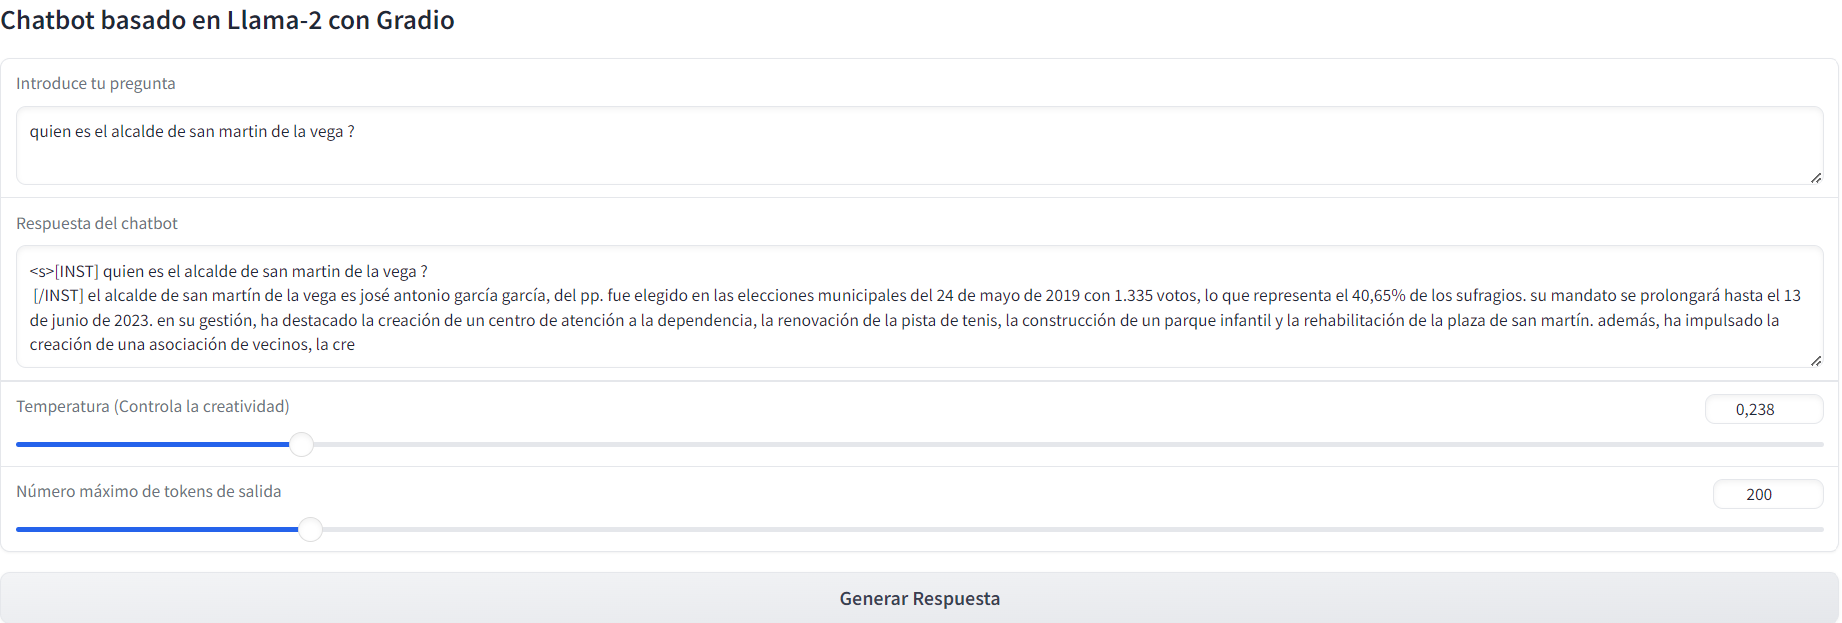

Por lo tanto, dejo aqui mi modelo que se puede cargar en cualquier momento y usar la app de gradio como interfaz de chatbot.